Imports

In [1]:
import random
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

Circuit Construction Function

In [2]:
def build_quantum_circuit(
    num_qubits,
    selected_gates,
    circuit_depth,
    gate_application,
    bug_flip_gate=False,
    bug_wrong_target=False,
):
    """
    Build a random quantum circuit with optional injected 'bugs'.
    """
    qc = QuantumCircuit(num_qubits, num_qubits)

    for layer in range(circuit_depth):
        for qubit in range(num_qubits):
            # choose gate
            if gate_application == "random":
                gate = random.choice(selected_gates)
            else:
                gate = selected_gates[layer % len(selected_gates)]

            # Simple bug: occasionally flip gate to X
            if bug_flip_gate and random.random() < 0.1:
                gate = "x"

            # Apply the gate
            if gate == "h":
                qc.h(qubit)
            elif gate == "x":
                qc.x(qubit)
            elif gate == "y":
                qc.y(qubit)
            elif gate == "z":
                qc.z(qubit)
            elif gate == "cx":
                if num_qubits >= 2:
                    if bug_wrong_target:
                        target = (qubit + 2) % num_qubits
                    else:
                        target = (qubit + 1) % num_qubits
                    qc.cx(qubit, target)
            elif gate == "ccx":
                if num_qubits >= 3:
                    control1 = qubit
                    control2 = (qubit + 1) % num_qubits
                    target = (qubit + (3 if bug_wrong_target else 2)) % num_qubits
                    qc.ccx(control1, control2, target)

    qc.measure(range(num_qubits), range(num_qubits))
    return qc

Noise Model and Simulation Functions

In [3]:
def build_simple_noise_model(p_gate=0.01, p_readout=0.02):
    """
    Very simple depolarizing + readout noise model.
    """
    noise_model = NoiseModel()

    single_qubit_error = depolarizing_error(p_gate, 1)
    two_qubit_error = depolarizing_error(p_gate, 2)

    for g in ["x", "y", "z", "h"]:
        noise_model.add_all_qubit_quantum_error(single_qubit_error, g)
    for g in ["cx", "cz"]:
        noise_model.add_all_qubit_quantum_error(two_qubit_error, g)

    readout = ReadoutError(
        [[1 - p_readout, p_readout], [p_readout, 1 - p_readout]]
    )
    noise_model.add_all_qubit_readout_error(readout)

    return noise_model


def simulate_circuit_ideal(qc, shots=1024):
    """
    Ideal (noise-free) simulation with AerSimulator.
    """
    backend = AerSimulator()
    qc_t = transpile(qc, backend)
    job = backend.run(qc_t, shots=shots)
    result = job.result()
    return result.get_counts()


def simulate_circuit_noisy(qc, noise_model, shots=1024):
    """
    Noisy simulation with a given NoiseModel.
    """
    backend = AerSimulator(noise_model=noise_model)
    qc_t = transpile(qc, backend)
    job = backend.run(qc_t, shots=shots)
    result = job.result()
    return result.get_counts()

IBM Hardware Function

In [17]:
def run_on_hardware(qc, backend_name="ibm_torino", shots=1024):
    """
    Run a measured circuit on an IBM Quantum backend using Qiskit Runtime Sampler.
    Assumes you have already saved your IBM Quantum account.
    """
    service = QiskitRuntimeService()
    backend = service.backend(backend_name)
    qc_t = transpile(qc, backend=backend)

    # Use Sampler with explicit shots
    sampler = Sampler(mode=backend, options={"default_shots": shots})
    job = sampler.run([qc_t])
    result = job.result()

    # SamplerResult V2: quasi-distribution per circuit
    pub_result = result[0]
    data_bin = pub_result.data
    bit_array = data_bin.c

    counts = bit_array.get_counts()
    return counts

Set Parameters Directly

In [5]:
# Circuit parameters (modify these directly instead of using CLI prompts)
num_qubits = 2
selected_gates = ["h", "cx"]
circuit_depth = 2
gate_application = "random"  # "random" or "sequential"

# Bug flags
bug_flip_gate = False
bug_wrong_target = False

# Hardware parameters
run_hardware = True  # Set to True to run on IBM hardware
hardware_backend = "ibm_torino"  # ibm_torino has no queue (much faster than ibm_fez)
shots = 256  # Reduced from 1024 for simulator
hardware_shots = 100  # Use minimal shots on real hardware to save time

Build and Display Circuits

In [6]:
# Build clean and buggy circuits
qc_clean = build_quantum_circuit(
    num_qubits,
    selected_gates,
    circuit_depth,
    gate_application,
    bug_flip_gate=False,
    bug_wrong_target=False,
)

qc_buggy = build_quantum_circuit(
    num_qubits,
    selected_gates,
    circuit_depth,
    gate_application,
    bug_flip_gate=bug_flip_gate,
    bug_wrong_target=bug_wrong_target,
)

print("Clean circuit:")
print(qc_clean.draw(output="text"))
print("\nBuggy circuit:")
print(qc_buggy.draw(output="text"))

Clean circuit:
     ┌───┐┌───┐┌───┐┌───┐┌─┐   
q_0: ┤ H ├┤ X ├┤ H ├┤ X ├┤M├───
     └───┘└─┬─┘└───┘└─┬─┘└╥┘┌─┐
q_1: ───────■─────────■───╫─┤M├
                          ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1 

Buggy circuit:
                         ┌─┐   
q_0: ──■─────────■───────┤M├───
     ┌─┴─┐┌───┐┌─┴─┐┌───┐└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ X ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘└───┘ ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1 


Run Simulations

In [7]:
# Create noise model
noise_model = build_simple_noise_model()

# Run simulations
counts_clean_ideal = simulate_circuit_ideal(qc_clean, shots=shots)
counts_clean_noisy = simulate_circuit_noisy(qc_clean, noise_model, shots=shots)
counts_buggy_noisy = simulate_circuit_noisy(qc_buggy, noise_model, shots=shots)

print("Clean ideal counts:")
print(counts_clean_ideal)
print("\nClean noisy counts:")
print(counts_clean_noisy)
print("\nBuggy noisy counts:")
print(counts_buggy_noisy)

Clean ideal counts:
{'00': 256}

Clean noisy counts:
{'00': 244, '11': 1, '10': 8, '01': 3}

Buggy noisy counts:
{'00': 247, '01': 5, '10': 3, '11': 1}


Visualize Simulation Results

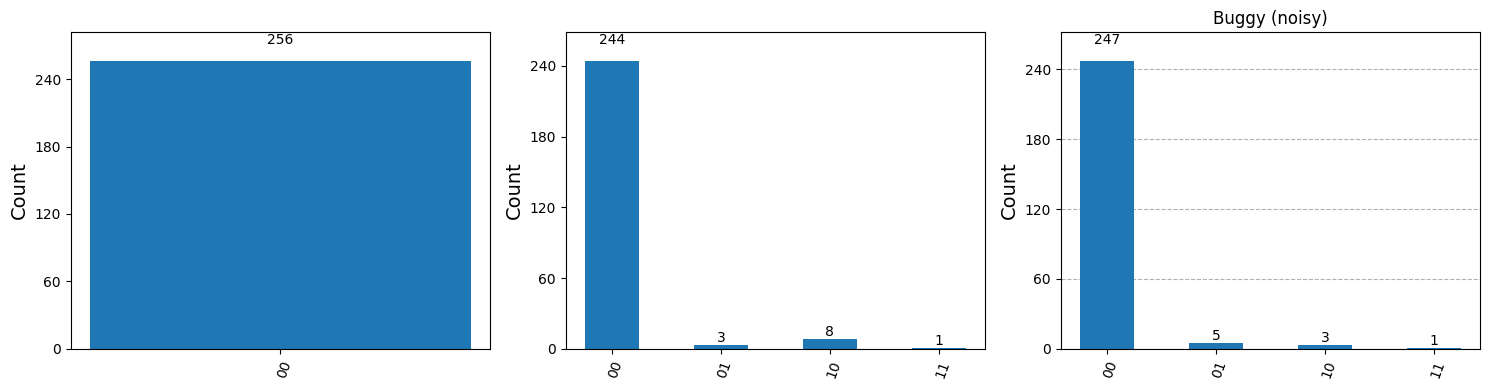

In [8]:
# Plot histograms
try:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    plot_histogram(counts_clean_ideal, ax=axes[0], title="Clean (ideal)")
    plot_histogram(counts_clean_noisy, ax=axes[1], title="Clean (noisy)")
    plot_histogram(counts_buggy_noisy, ax=axes[2], title="Buggy (noisy)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred while plotting histograms: {e}")

## Run on IBM Hardware (Optional)

Analyze Noise Distribution Changes (Bug Detection)

In [ ]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def analyze_bug_impact(counts_clean, counts_buggy, shots):
    """
    Compare noise distributions between clean and buggy circuits.
    Returns metrics that could indicate bugs in real quantum systems.
    """
    # Convert counts to probability distributions
    clean_probs = {k: v / shots for k, v in counts_clean.items()}
    buggy_probs = {k: v / shots for k, v in counts_buggy.items()}
    
    # Get all possible bitstrings
    all_bitstrings = set(clean_probs.keys()) | set(buggy_probs.keys())
    
    # Create normalized distributions
    clean_dist = np.array([clean_probs.get(bs, 0) for bs in sorted(all_bitstrings)])
    buggy_dist = np.array([buggy_probs.get(bs, 0) for bs in sorted(all_bitstrings)])
    
    # Calculate divergence metrics
    js_divergence = jensenshannon(clean_dist, buggy_dist)  # 0=identical, 1=completely different
    l1_distance = np.sum(np.abs(clean_dist - buggy_dist)) / 2
    
    # Entropy of each distribution
    clean_entropy = -np.sum(clean_dist[clean_dist > 0] * np.log2(clean_dist[clean_dist > 0]))
    buggy_entropy = -np.sum(buggy_dist[buggy_dist > 0] * np.log2(buggy_dist[buggy_dist > 0]))
    
    return {
        "js_divergence": js_divergence,
        "l1_distance": l1_distance,
        "clean_entropy": clean_entropy,
        "buggy_entropy": buggy_entropy,
        "entropy_change": buggy_entropy - clean_entropy,
        "clean_probs": clean_probs,
        "buggy_probs": buggy_probs
    }

# Run analysis on simulator results
print("=== NOISE DISTRIBUTION ANALYSIS ===\n")
metrics = analyze_bug_impact(counts_clean_ideal, counts_buggy_noisy, shots)

print(f"Jensen-Shannon Divergence: {metrics['js_divergence']:.4f}")
print(f"  (0 = identical, 1 = completely different)")
print(f"\nL1 Distance: {metrics['l1_distance']:.4f}")
print(f"  (How much probability mass shifted between states)")
print(f"\nEntropy (randomness):")
print(f"  Clean ideal: {metrics['clean_entropy']:.4f} bits")
print(f"  Buggy noisy: {metrics['buggy_entropy']:.4f} bits")
print(f"  Change: {metrics['entropy_change']:+.4f} bits")

print(f"\nClean distributions:")
for bitstr, prob in sorted(metrics['clean_probs'].items()):
    print(f"  {bitstr}: {prob:.4f}")

print(f"\nBuggy distributions:")
for bitstr, prob in sorted(metrics['buggy_probs'].items()):
    print(f"  {bitstr}: {prob:.4f}")

# BUG DETECTION HEURISTIC
print(f"\n=== BUG DETECTION HEURISTIC ===")
if metrics['js_divergence'] > 0.1:
    print(f"High Divergence: Significant difference detected!")
    print(f"   Suggests potential circuit bug or major noise change")
elif metrics['js_divergence'] > 0.05:
    print(f"Moderate Divergence: Some difference detected")
    print(f"   Could indicate minor bugs or noise variations")
else:
    print(f"Low Divergence: Distributions very similar")
    print(f"  Bugs/noise not clearly detectable at this shot count")

=== NOISE DISTRIBUTION ANALYSIS ===

Jensen-Shannon Divergence: 0.1111
  (0 = identical, 1 = completely different)

L1 Distance: 0.0352
  (How much probability mass shifted between states)

Entropy (randomness):
  Clean ideal: -0.0000 bits
  Buggy noisy: 0.2671 bits
  Change: +0.2671 bits

Clean distributions:
  00: 1.0000

Buggy distributions:
  00: 0.9648
  01: 0.0195
  10: 0.0117
  11: 0.0039

=== BUG DETECTION HEURISTIC ===
⚠️  HIGH DIVERGENCE: Significant difference detected!
   Suggests potential circuit bug or major noise change


Running on IBM hardware backend: ibm_torino
Using 100 shots to minimize queue time...

Hardware counts:
{'00': 97, '11': 1, '10': 2}


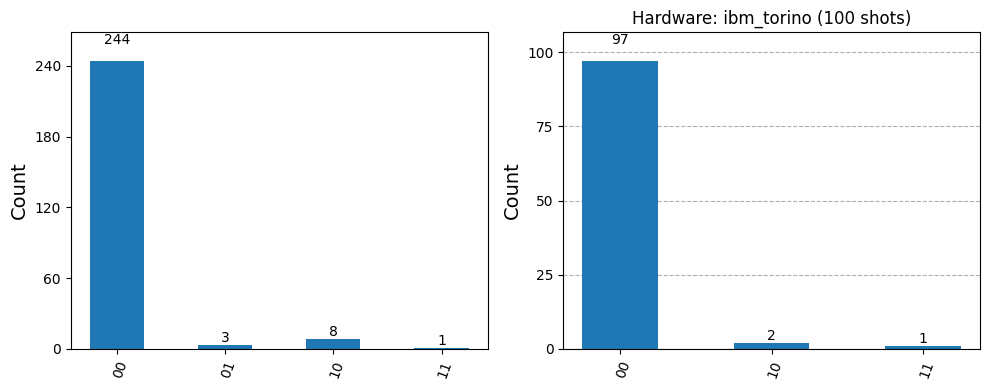

In [18]:
if run_hardware:
    print(f"Running on IBM hardware backend: {hardware_backend}")
    print(f"Using {hardware_shots} shots to minimize queue time...")
    counts_hw = run_on_hardware(qc_clean, hardware_backend, shots=hardware_shots)
    print("\nHardware counts:")
    print(counts_hw)
    
    # Quick visual compare: noisy sim vs hardware
    try:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        plot_histogram(counts_clean_noisy, ax=axes[0], title="Clean (noisy simulator)")
        plot_histogram(counts_hw, ax=axes[1], title=f"Hardware: {hardware_backend} ({hardware_shots} shots)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting hardware results: {e}")
else:
    print("Hardware run disabled. Set run_hardware=True to run on IBM hardware.")

Compare Hardware vs Simulator to Find Real Bugs

Running on IBM hardware backend: ibm_torino
Using 100 shots to minimize queue time...

Hardware counts:
{'00': 98, '11': 1, '10': 1}

=== HARDWARE vs SIMULATORS ANALYSIS ===

Hardware divergence from ideal: 0.0836
Simulator divergence from ideal: 0.1286

Difference: 0.0450
✓ Hardware noise matches simulator model reasonably well


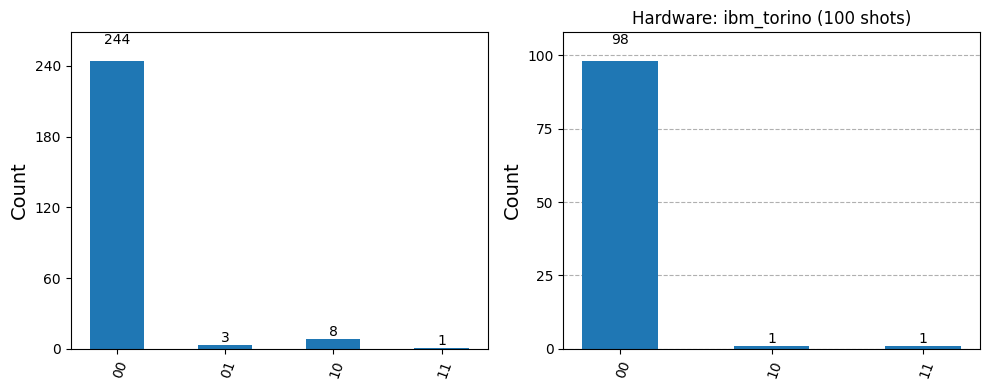

In [19]:
if run_hardware:
    print(f"Running on IBM hardware backend: {hardware_backend}")
    print(f"Using {hardware_shots} shots to minimize queue time...")
    counts_hw = run_on_hardware(qc_clean, hardware_backend, shots=hardware_shots)
    print("\nHardware counts:")
    print(counts_hw)
    
    # Compare hardware with simulators
    print(f"\n=== HARDWARE vs SIMULATORS ANALYSIS ===\n")
    
    hw_metrics = analyze_bug_impact(counts_clean_ideal, counts_hw, hardware_shots)
    sim_metrics = analyze_bug_impact(counts_clean_ideal, counts_clean_noisy, shots)
    
    print(f"Hardware divergence from ideal: {hw_metrics['js_divergence']:.4f}")
    print(f"Simulator divergence from ideal: {sim_metrics['js_divergence']:.4f}")
    print(f"\nDifference: {abs(hw_metrics['js_divergence'] - sim_metrics['js_divergence']):.4f}")
    
    if abs(hw_metrics['js_divergence'] - sim_metrics['js_divergence']) > 0.1:
        print("⚠️  Hardware noise model mismatch!")
        print("   Real hardware has different noise characteristics than simulator")
        print("   → Could indicate unmodeled noise sources (crosstalk, calibration drift, etc.)")
    else:
        print("✓ Hardware noise matches simulator model reasonably well")
    
    # Quick visual compare: noisy sim vs hardware
    try:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        plot_histogram(counts_clean_noisy, ax=axes[0], title="Clean (noisy simulator)")
        plot_histogram(counts_hw, ax=axes[1], title=f"Hardware: {hardware_backend} ({hardware_shots} shots)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting hardware results: {e}")
else:
    print("Hardware run disabled. Set run_hardware=True to run on IBM hardware.")